## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from word_segmentation import WordSegmentation
from evaluations import Evaluator

sns.set_theme(style="darkgrid")

## 2. Example prediction

### 2.1. Load parameters
You can load parameters from file or pass the parameters to the `WordSegmentation` constructor.

In [2]:
word_segmentation = WordSegmentation()
word_segmentation.load_params('page_params')
word_segmentation.get_params()

{'kernel_size': 25,
 'sigma': 11,
 'theta': 5,
 'min_word_area': 100,
 'resize_height': 1000}

### 2.2. Predict page

Processing image 1/4: ./data/page/d06-050.png


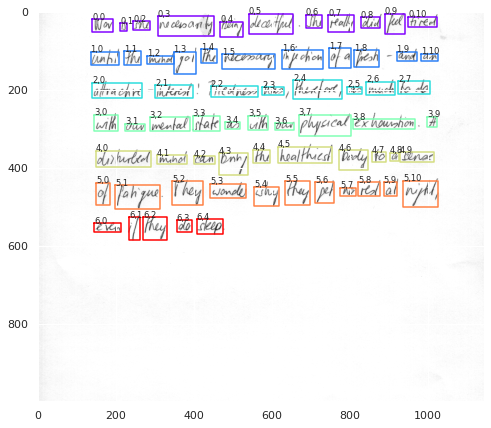

Processing image 2/4: ./data/page/d07-082.png


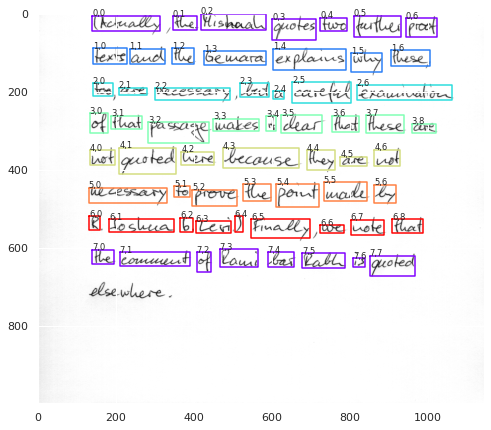

Processing image 3/4: ./data/page/b04-103.png


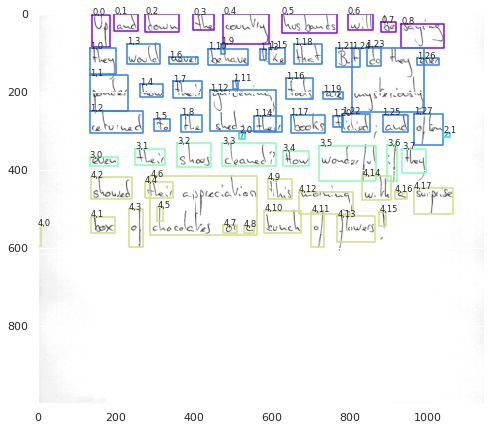

Processing image 4/4: ./data/page/a04-039.png


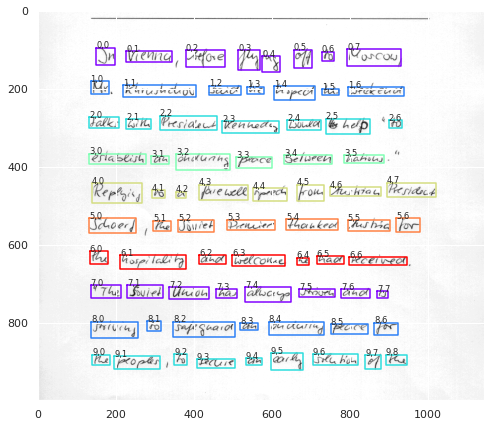

({'d06-050': [[<entities.Word at 0x7f1c06b347f0>,
  'd07-082': [[<entities.Word at 0x7f1c05ea73a0>,
  'b04-103': [[<entities.Word at 0x7f1c04e64880>,
   [<entities.Word at 0x7f1c04e59280>, <entities.Word at 0x7f1c04e59fd0>],
  'a04-039': [[<entities.Word at 0x7f1c04cc5670>,
    <entities.Word at 0x7f1c04e625e0>]]},
 {'d06-050': 2.077, 'd07-082': 2.077, 'b04-103': 2.077, 'a04-039': 2.077})

In [3]:
word_segmentation.predict(data='./data/page', is_visualized=True)

### 2.3. Predict line

Processing image 1/6: ./data/line/2.png


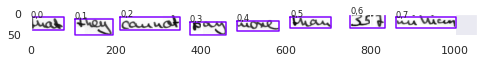

Processing image 2/6: ./data/line/3.png


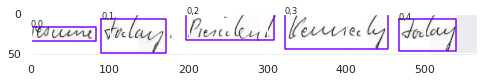

Processing image 3/6: ./data/line/0.png


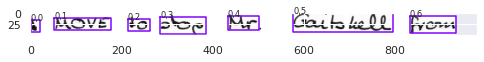

Processing image 4/6: ./data/line/4.png


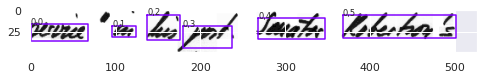

Processing image 5/6: ./data/line/5.png


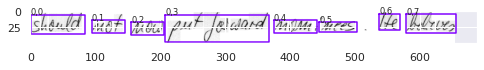

Processing image 6/6: ./data/line/1.png


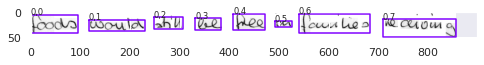

({'2': [[<entities.Word at 0x7f1c013398b0>,
  '3': [[<entities.Word at 0x7f1c012726a0>,
  '0': [[<entities.Word at 0x7f1c0125bc70>,
  '4': [[<entities.Word at 0x7f1c011bcd90>,
  '5': [[<entities.Word at 0x7f1c01152d90>,
  '1': [[<entities.Word at 0x7f1c010c6880>,
    <entities.Word at 0x7f1c010bf880>]]},
 {'2': 1.8199999999999998,
  '3': 3.4,
  '0': 1.7799999999999998,
  '4': 3.6599999999999997,
  '5': 2.88,
  '1': 2.3400000000000003})

In [4]:
word_segmentation_line = WordSegmentation(kernel_size=25,
                                          sigma=11,
                                          theta=7,
                                          min_word_area=100,
                                          resize_height=50)

word_segmentation_line.predict(data='./data/line', is_visualized=True)

## 3. Choose parameters

### 3.1. Sigma and Theta
In order to choose value for `sigma`, we will loop for all sigma values and caculate the maximum area of all words (or we can call extent pixels) detected by the word segmentation.

In [5]:
%%capture capt
def calculate_extent(pages):
    area = 0
    for img_id, lines in pages.items():
        for line in lines:
            for word in line:
                area += word.box.area()
    return area

def calculate_extent_line_of_sigma():
    points = []
    MIN_SIGMA, MAX_SIGMA, STEP = 1, 10, 0.1
    sigma = MIN_SIGMA
    while sigma <= MAX_SIGMA:
        word_segmentation = WordSegmentation(kernel_size=25,
                                             sigma=sigma,
                                             theta=4,
                                             min_word_area=100,
                                             resize_height=1000)
        results, rescale_factor = word_segmentation.predict(data='./data/page')
        points.append((sigma, calculate_extent(results)))
        sigma += STEP
    return points

sigma_points = calculate_extent_line_of_sigma()

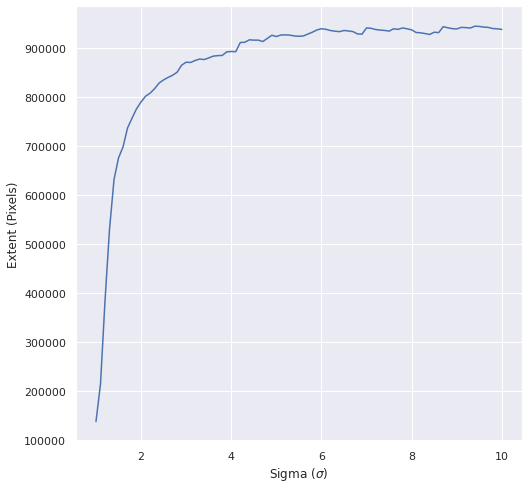

In [6]:
figure, ax = plt.subplots(figsize=(8, 8))
x = [point[0] for point in sigma_points]
y = [point[1] for point in sigma_points]
ax = sns.lineplot(x=x, y=y, ax=ax)
ax.set_xlabel(r"Sigma ($\sigma$)")
ax.set_ylabel("Extent (Pixels)")
plt.show(figure)

In [7]:
figure.savefig('./visualizations/sigma_choice.png', dpi=400)

We can see the the `sigma` value starts to converge from `sigma > 6`. Therefor, we can choose the `sigma` value in the range `[5-7]`.

With `theta` value, we applies the same way to figure out the best parameter.

In [8]:
%%capture capt
def calculate_extent_line_of_theta():
    points = []
    MIN_THETA, MAX_THETA, STEP = 0.3, 10, 0.1
    theta = MIN_THETA
    while theta <= MAX_THETA:
        word_segmentation = WordSegmentation(kernel_size=25,
                                             sigma=5,
                                             theta=theta,
                                             min_word_area=100,
                                             resize_height=1000)
        results, rescale_factor = word_segmentation.predict(data='./data/page')
        points.append((theta, calculate_extent(results)))
        theta += STEP
    return points

theta_points = calculate_extent_line_of_theta()

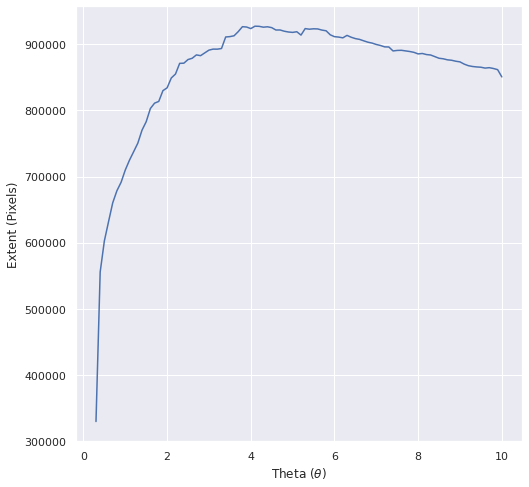

In [9]:
figure, ax = plt.subplots(figsize=(8, 8))
x = [point[0] for point in theta_points]
y = [point[1] for point in theta_points]
ax = sns.lineplot(x=x, y=y, ax=ax)
ax.set_xlabel(r"Theta ($\theta$)")
ax.set_ylabel("Extent (Pixels)")
figure.savefig('./visualizations/theta_choice.png', dpi=400)
plt.show(figure)

As we can see, `theta` value reaches the peak at `theta ~ 4`. There, we can choose `theta` in the range `[3-5]`.

### 3.2. Min word area
To choose the good min word area value, we plots histogram of area of all words.

In [10]:
with open('./data/words.txt') as f:
    lines = f.read().split('\n')[18:]
areas = []
for line in lines:
    word_id, status, gray_level, x, y, w, h = line.split(' ')[:7]
    areas.append(int(w) * int(h))
areas = sorted(areas)

print('Count words:', len(areas))
print('Top 3.5% smallest word areas:', areas[round(len(areas) * 0.035)])

Count words: 115320
Top 3.5% smallest word areas: 96


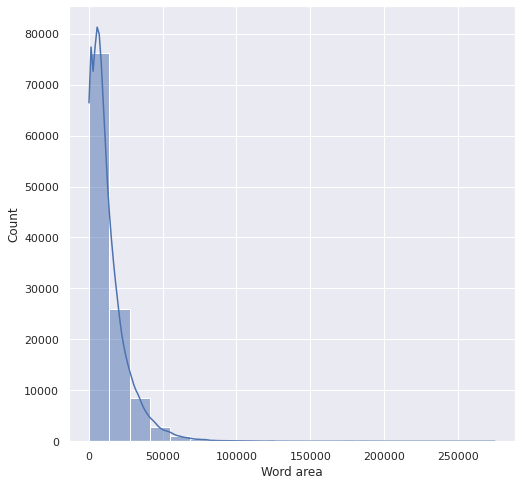

In [11]:
figure, ax = plt.subplots(figsize=(8, 8))
ax = sns.histplot(data=areas, ax=ax, bins=20, kde=True)
ax.set_xlabel(r"Word area")
ax.set_ylabel("Count")
figure.savefig('./visualizations/word_area_hist.png', dpi=400)
plt.show(figure)

We can choose `min_word_area=100` because only ~3.5% of words in the dataset lower than that threshold.

### 3.3. Kernel size and resize height
`kernel_size = 25` and `resize_height = 1000` are choose from guessing and referencing from the paper and other sources. The `resize_height` correlates with the `kernel_size`: the resized image needs to ensure that the average word height is roughly equal to the kernel size.

## 4. Parameters tuning
We try some combinations of parameters to find out the best combination.

In [12]:
%%capture capt
sigmas = [5, 6, 7]
thetas = [4, 5]
resize_heights = [700, 800]

results = []
for sigma in sigmas:
    for theta in thetas:
        for resize_height in resize_heights:
            evaluator = Evaluator()
            results.append({
                'sigma': sigma,
                'theta': theta,
                'resize_height': resize_height,
                'score': evaluator.evaluate(kernel_size=25,
                                            sigma=sigma,
                                            theta=theta,
                                            min_word_area=100,
                                            resize_height=resize_height)
            })

In [13]:
sorted(results, key=lambda item: item['score'])

[{'sigma': 7, 'theta': 5, 'resize_height': 700, 'score': 0.41946500996950553},
 {'sigma': 6, 'theta': 5, 'resize_height': 700, 'score': 0.43133457426602845},
 {'sigma': 7, 'theta': 4, 'resize_height': 700, 'score': 0.43743023737332554},
 {'sigma': 7, 'theta': 5, 'resize_height': 800, 'score': 0.4394564468073748},
 {'sigma': 5, 'theta': 5, 'resize_height': 700, 'score': 0.44225394004692886},
 {'sigma': 6, 'theta': 5, 'resize_height': 800, 'score': 0.44280963600121803},
 {'sigma': 5, 'theta': 5, 'resize_height': 800, 'score': 0.44584354116604274},
 {'sigma': 6, 'theta': 4, 'resize_height': 700, 'score': 0.446550208935305},
 {'sigma': 7, 'theta': 4, 'resize_height': 800, 'score': 0.4481743504738732},
 {'sigma': 5, 'theta': 4, 'resize_height': 700, 'score': 0.4520353411541134},
 {'sigma': 5, 'theta': 4, 'resize_height': 800, 'score': 0.4539526809678923},
 {'sigma': 6, 'theta': 4, 'resize_height': 800, 'score': 0.4553221287663354}]

In conclusion, beside `kernel_size = 25` and `min_word_area = 100`, the parameters `sigma = 5`, `theta = 4`, `resize_height = 800` give the best performance.